In [1]:
pip list

Package                            Version
---------------------------------- -------------------
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 1.10.0
anaconda-project                   0.8.3
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astroid                            2.4.2
astropy                            4.0.2
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              20.3.0
autopep8                           1.5.4
Babel                              2.8.1
backcall                           0.2.0
backports.functools-lru-cache      1.6.1
backports.shutil-get-terminal-size 1.0.0
backports.tempfile                 1.0
backports.weakref                  1.0.post1
bcrypt                             3.2.0
beautifulsoup4                     4.9.3
bitarray                           

## 如何安装cuda直接在promt里面输入该指令pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117 +清华源

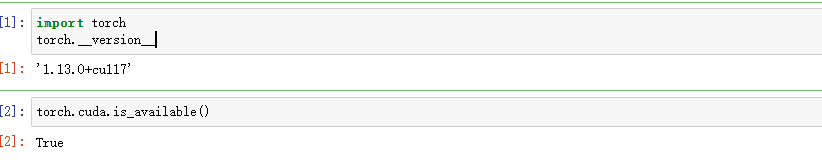

In [1]:
import torch
torch.__version__

'2.0.1+cu117'

In [2]:
torch.cuda.is_available()

True

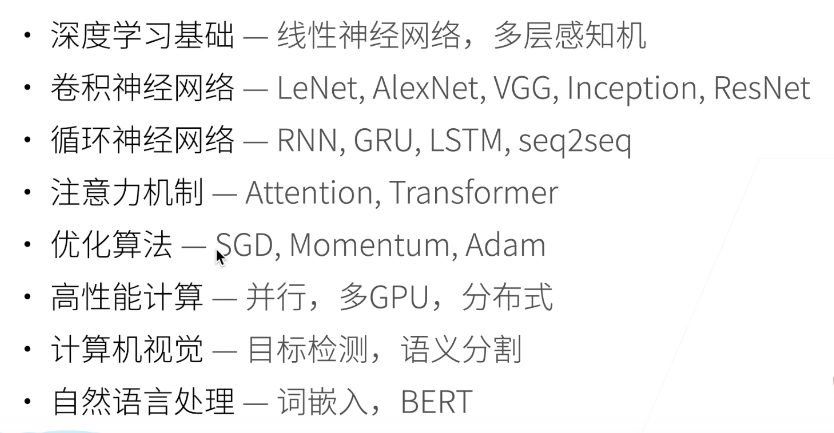

In [11]:
import numpy as np

In [3]:
!nvidia-smi

Tue Mar 28 20:09:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   45C    P5    23W / 200W |   1020MiB /  8192MiB |     30%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from keras.datasets.mnist import load_data

# load (and normalize) mnist dataset
(trainX, trainy), (testX, testy) = load_data()
trainX = (np.float32(trainX) - 127.5) / 127.5


def get_minibatch(batch_size):
    indices = torch.randperm(trainX.shape[0])[:batch_size]
    return torch.tensor(trainX[indices], dtype=torch.float).reshape(batch_size, -1)


def sample_noise(size, dim=100):
    out = torch.empty(size, dim)
    mean = torch.zeros(size, dim)
    std = torch.ones(dim)
    torch.normal(mean, std, out=out)
    return out


class Generator(nn.Module):

    def __init__(self, input_dim=100, hidden_dim=1200, output_dim=28 * 28):
        super(Generator, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh(), )

    def forward(self, noise):
        return self.network(noise)


class Discriminator(nn.Module):

    def __init__(self, input_dim=28 * 28, hidden_dim=240, output_dim=1):
        super(Discriminator, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid(), )

    def forward(self, x):
        return self.network(x)


def train(generator, discriminator, generator_optimizer, discriminator_optimizer, nb_epochs, k=1, batch_size=100):
    training_loss = {'generative': [], 'discriminator': []}
    training_accuracy = []

    for epoch in tqdm(range(nb_epochs)):
        d_losses = []
        g_losses = []
        correct_real = 0
        correct_fake = 0
        total = 0

        # Train the discriminator
        for _ in range(k):
            z = sample_noise(batch_size).to(device)
            x = get_minibatch(batch_size).to(device)

            # Update the discriminator
            f_output = discriminator(generator(z)).reshape(batch_size)
            r_output = discriminator(x).reshape(batch_size)

            f_loss = torch.nn.BCELoss()(f_output, torch.zeros(batch_size, device=device))
            r_loss = torch.nn.BCELoss()(r_output, torch.ones(batch_size, device=device))

            loss = (r_loss + f_loss) / 2
            discriminator_optimizer.zero_grad()
            loss.backward()
            discriminator_optimizer.step()
            d_losses.append(loss.item())

            # Calculate discriminator accuracy
            predicted_real = torch.round(r_output)
            predicted_fake = torch.round(f_output)
            correct_real += (predicted_real == 1).sum().item()
            correct_fake += (predicted_fake == 0).sum().item()
            total += batch_size

        discriminator_accuracy = 100 * (correct_real + correct_fake) / (2 * total)

        # Train the generator
        z = sample_noise(batch_size).to(device)
        f_output = discriminator(generator(z)).reshape(batch_size)

        # Update the generator
        loss = torch.nn.BCELoss()(f_output, torch.ones(batch_size, device=device))
        generator_optimizer.zero_grad()
        loss.backward()
        generator_optimizer.step()
        g_losses.append(loss.item())

        # Calculate generator accuracy
        predicted_fake = torch.round(f_output)
        correct_fake = (predicted_fake == 1).sum().item()
        generator_accuracy = 100 * correct_fake / batch_size

        training_loss['discriminator'].extend(d_losses)
        training_loss['generative'].extend(g_losses)
        training_accuracy.append((discriminator_accuracy, generator_accuracy))

        # Print training progress every 1000 epochs
        if (epoch+1) % 1000 == 0:
            print(f"Epoch [{epoch+1}/{nb_epochs}], "
                  f"Discriminator Loss: {np.mean(d_losses):.4f}, "
                  f"Generator Loss: {np.mean(g_losses):.4f}, "
                  f"Discriminator Accuracy: {discriminator_accuracy:.2f}%, "
                  f"Generator Accuracy: {generator_accuracy:.2f}%")
        
        # Save the generator and discriminator models every 1000 epochs
        if (epoch+1) % 1000 == 0:
            torch.save(generator.state_dict(), f"D:\models\generator_epoch_{epoch+1}.pt")
            torch.save(discriminator.state_dict(), f"D:\models\discriminator_epoch_{epoch+1}.pt")

    return training_loss, training_accuracy

    return training_loss, training_accuracy



if __name__ == "__main__":
    device = 'cuda:0'

    discriminator = Discriminator().to(device)
    generator = Generator().to(device)

    optimizer_d = optim.SGD(discriminator.parameters(), lr=0.1, momentum=0.5)
    optimizer_g = optim.SGD(generator.parameters(), lr=0.1, momentum=0.5)
    
    loss = train(generator, discriminator, optimizer_g, optimizer_d, 10000, batch_size=1000)

    # Sample and plot images from the trained generator
    NB_IMAGES = 25
    z = sample_noise(NB_IMAGES).to(device)
    x = generator(z)
    plt.figure(figsize=(17, 17))
    for i in range(NB_IMAGES):
        plt.subplot(5, 5, 1 + i)
        plt.axis('off')
        plt.imshow(x[i].data.cpu().numpy().reshape(28, 28), cmap='gray')
    plt.savefig("q.png")
    plt.show()

In [ ]:
import os
import sys
import xml.etree.ElementTree as ET
import glob
 
def xml_to_txt(indir,outdir):
 
    os.chdir(indir)
    annotations = os.listdir('.')
    annotations = glob.glob(str(annotations)+'*.xml')
    print(annotations)
    for i, file in enumerate(annotations):
 
        file_save = file.split('.')[0]+'.txt'
        # file_txt=os.path.join(outdir,file_save)
        file_txt = outdir+"\\"+file_save
        # print(file_save)
        f_w = open(file_txt, 'w')
 
        # actual parsing
        in_file = open(file)
        tree=ET.parse(in_file)
        root = tree.getroot()
        filename = root.find('filename').text  #这里是xml的根，获取filename那一栏
        for obj in root.iter('object'):
                current = list()
                name = obj.find('name').text   #这里获取多个框的名字，底下是获取每个框的位置
 
                xmlbox = obj.find('bndbox')
                xn = xmlbox.find('xmin').text   
                xx = xmlbox.find('xmax').text
                yn = xmlbox.find('ymin').text
                yx = xmlbox.find('ymax').text
                #print xn
                f_w.write(filename +' '+xn+' '+yn+' '+xx+' '+yx+' ')
                f_w.write(name+'\n')
 
indir='.\\BCCD\\Annotations'   #xml目录
outdir='./BCCD/Annotations_txt'  #txt目录
 
xml_to_txt(indir,outdir)

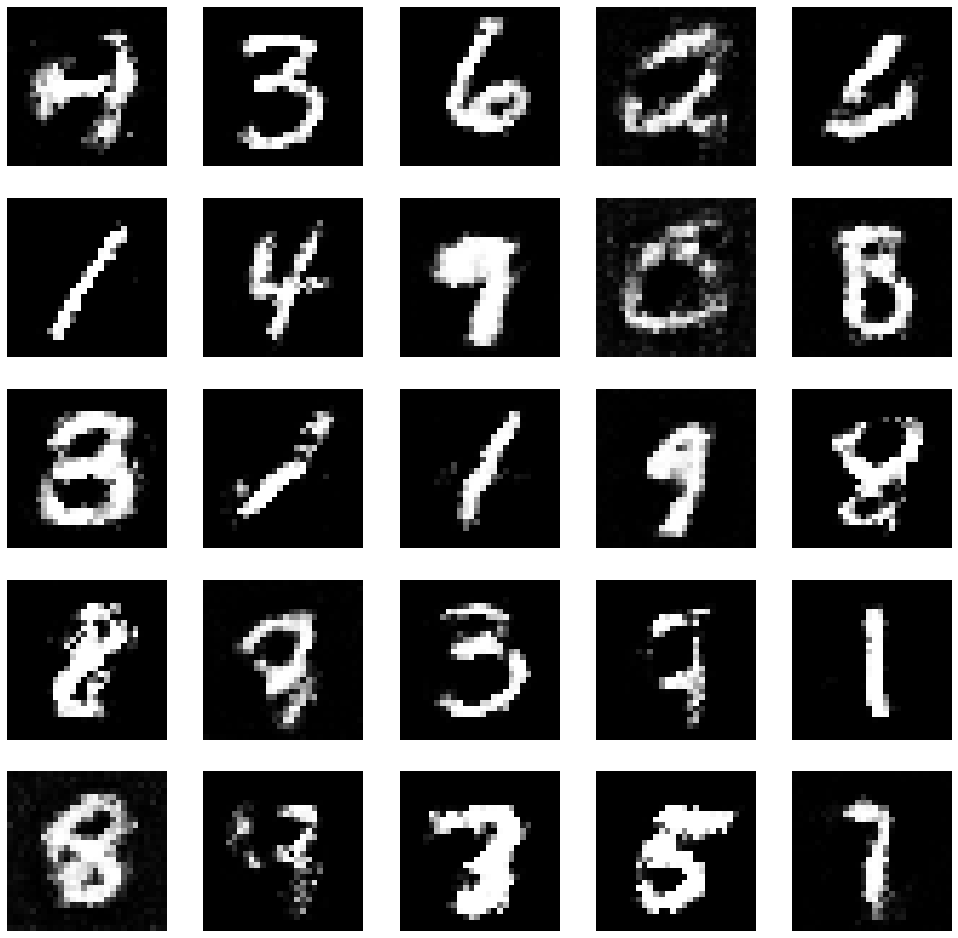

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from keras.datasets.mnist import load_data

# load (and normalize) mnist dataset
(trainX, trainy), (testX, testy) = load_data()
trainX = (np.float32(trainX) - 127.5) / 127.5

# Define the Generator and Discriminator classes

# Define the training function

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the generator model
generator = Generator().to(device)
generator.load_state_dict(torch.load('D:/models/generator_last.pt', map_location=device))
generator.eval()

# Generate images
NB_IMAGES = 25
z = sample_noise(NB_IMAGES).to(device)
with torch.no_grad():  # Disable gradient tracking
    generated_images = generator(z)

# Convert images to NumPy arrays and display
plt.figure(figsize=(17, 17))
for i in range(NB_IMAGES):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(generated_images[i].detach().cpu().numpy().reshape(28, 28), cmap='gray')

plt.show()


 10%|███████▋                                                                    | 1015/10000 [00:04<00:41, 214.40it/s]

Epoch [1000/10000], Discriminator Loss: 0.5007, Generator Loss: 1.7286, Discriminator Accuracy: 73.00%, Generator Accuracy: 7.00%


 20%|███████████████▎                                                            | 2016/10000 [00:08<00:35, 224.21it/s]

Epoch [2000/10000], Discriminator Loss: 0.4747, Generator Loss: 1.4238, Discriminator Accuracy: 69.00%, Generator Accuracy: 17.00%


 30%|███████████████████████                                                     | 3038/10000 [00:13<00:30, 225.51it/s]

Epoch [3000/10000], Discriminator Loss: 0.4673, Generator Loss: 1.5377, Discriminator Accuracy: 69.00%, Generator Accuracy: 8.00%


 40%|██████████████████████████████▌                                             | 4014/10000 [00:17<00:28, 208.49it/s]

Epoch [4000/10000], Discriminator Loss: 0.5529, Generator Loss: 1.1978, Discriminator Accuracy: 57.00%, Generator Accuracy: 25.00%


 50%|██████████████████████████████████████▏                                     | 5030/10000 [00:22<00:22, 223.01it/s]

Epoch [5000/10000], Discriminator Loss: 0.5165, Generator Loss: 1.2983, Discriminator Accuracy: 60.00%, Generator Accuracy: 23.00%


 60%|█████████████████████████████████████████████▊                              | 6036/10000 [00:26<00:17, 226.59it/s]

Epoch [6000/10000], Discriminator Loss: 0.4882, Generator Loss: 1.2979, Discriminator Accuracy: 67.00%, Generator Accuracy: 19.00%


 70%|█████████████████████████████████████████████████████▍                      | 7034/10000 [00:30<00:13, 219.35it/s]

Epoch [7000/10000], Discriminator Loss: 0.5184, Generator Loss: 0.8984, Discriminator Accuracy: 57.00%, Generator Accuracy: 40.00%


 80%|████████████████████████████████████████████████████████████▉               | 8022/10000 [00:35<00:09, 219.55it/s]

Epoch [8000/10000], Discriminator Loss: 0.5304, Generator Loss: 1.3775, Discriminator Accuracy: 75.00%, Generator Accuracy: 14.00%


 90%|████████████████████████████████████████████████████████████████████▌       | 9017/10000 [00:39<00:04, 219.99it/s]

Epoch [9000/10000], Discriminator Loss: 0.5654, Generator Loss: 1.0060, Discriminator Accuracy: 58.00%, Generator Accuracy: 32.00%


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:43<00:00, 227.48it/s]


Epoch [10000/10000], Discriminator Loss: 0.5453, Generator Loss: 1.4616, Discriminator Accuracy: 62.00%, Generator Accuracy: 13.00%


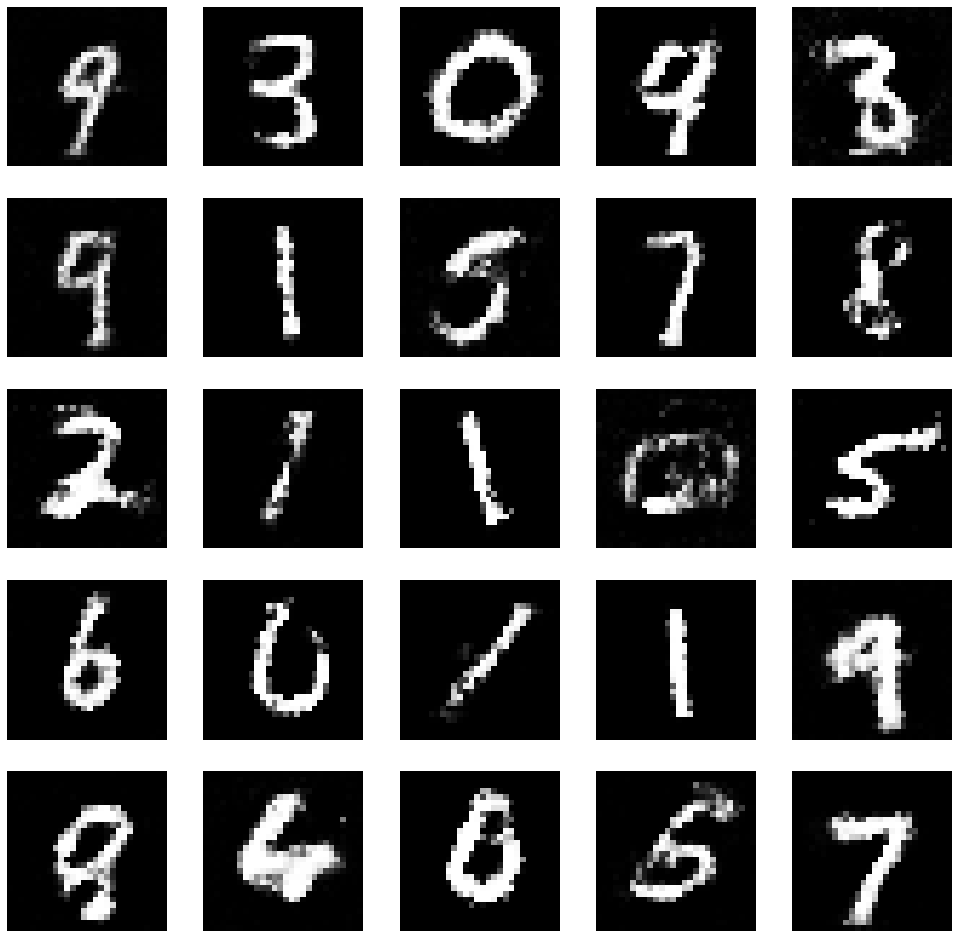

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from keras.datasets.mnist import load_data

# load (and normalize) mnist dataset
(trainX, trainy), (testX, testy) = load_data()
trainX = (np.float32(trainX) - 127.5) / 127.5


def get_minibatch(batch_size):
    indices = torch.randperm(trainX.shape[0])[:batch_size]
    return torch.tensor(trainX[indices], dtype=torch.float).reshape(batch_size, -1)


def sample_noise(size, dim=100):
    out = torch.empty(size, dim)
    mean = torch.zeros(size, dim)
    std = torch.ones(dim)
    torch.normal(mean, std, out=out)
    return out


class Generator(nn.Module):
    def __init__(self, input_dim=100, hidden_dim=1200, output_dim=28 * 28):
        super(Generator, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Tanh()
        )

    def forward(self, noise):
        return self.network(noise)


class Discriminator(nn.Module):
    def __init__(self, input_dim=28 * 28, hidden_dim=240, output_dim=1):
        super(Discriminator, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)


def train(generator, discriminator, generator_optimizer, discriminator_optimizer, nb_epochs, k=1, batch_size=100):
    training_loss = {'generative': [], 'discriminator': []}
    training_accuracy = []

    for epoch in tqdm(range(nb_epochs)):
        d_losses = []
        g_losses = []
        correct_real = 0
        correct_fake = 0
        total = 0

        # Train the discriminator
        for _ in range(k):
            z = sample_noise(batch_size).to(device)
            x = get_minibatch(batch_size).to(device)

            # Update the discriminator
            f_output = discriminator(generator(z)).reshape(batch_size)
            r_output = discriminator(x).reshape(batch_size)

            f_loss = torch.nn.BCELoss()(f_output, torch.zeros(batch_size, device=device))
            r_loss = torch.nn.BCELoss()(r_output, torch.ones(batch_size, device=device))

            loss = (r_loss + f_loss) / 2
            discriminator_optimizer.zero_grad()
            loss.backward()
            discriminator_optimizer.step()
            d_losses.append(loss.item())

        # Train the generator
        z = sample_noise(batch_size).to(device)
        f_output = discriminator(generator(z)).reshape(batch_size)
        g_loss = torch.nn.BCELoss()(f_output, torch.ones(batch_size, device=device))
        generator_optimizer.zero_grad()
        g_loss.backward()
        generator_optimizer.step()
        g_losses.append(g_loss.item())

        # Calculate discriminator accuracy
        predicted_real = torch.round(r_output)
        correct_real = (predicted_real == 1).sum().item()
        discriminator_accuracy = 100 * correct_real / batch_size

        # Calculate generator accuracy
        predicted_fake = torch.round(f_output)
        correct_fake = (predicted_fake == 1).sum().item()
        generator_accuracy = 100 * correct_fake / batch_size

        training_loss['discriminator'].extend(d_losses)
        training_loss['generative'].extend(g_losses)
        training_accuracy.append((discriminator_accuracy, generator_accuracy))

        # Print training progress every 1000 epochs
        if (epoch + 1) % 1000 == 0:
            print(f"Epoch [{epoch + 1}/{nb_epochs}], "
                  f"Discriminator Loss: {np.mean(d_losses):.4f}, "
                  f"Generator Loss: {np.mean(g_losses):.4f}, "
                  f"Discriminator Accuracy: {discriminator_accuracy:.2f}%, "
                  f"Generator Accuracy: {generator_accuracy:.2f}%")

        # Save the generator and discriminator models every 1000 epochs
        if (epoch + 1) % 1000 == 0:
            generator_path = f"D:/models/generator_last.pt"
            discriminator_path = f"D:/models/discriminator_last.pt"
            torch.save(generator.state_dict(), generator_path)
            torch.save(discriminator.state_dict(), discriminator_path)

#             # Delete previous generator and discriminator models
#             if epoch > 0:
#                 prev_generator_path = f"D:/models/generator_epoch_{(epoch)}.pt"
#                 prev_discriminator_path = f"D:/models/discriminator_epoch_{(epoch)}.pt"
    return training_loss, training_accuracy


if __name__ == "__main__":
    import os
    device = 'cuda:0'

    discriminator = Discriminator().to(device)
    generator = Generator().to(device)

    optimizer_d = optim.SGD(discriminator.parameters(), lr=0.1, momentum=0.5)
    optimizer_g = optim.SGD(generator.parameters(), lr=0.1, momentum=0.5)

    # Load the last saved generator and discriminator models
    last_epoch = 10000  # Set the value of the last saved epoch
    generator_path = f"D:/models/generator_last.pt"
    discriminator_path = f"D:/models/discriminator_last.pt"
    generator.load_state_dict(torch.load(generator_path))
    discriminator.load_state_dict(torch.load(discriminator_path))

    loss = train(generator, discriminator, optimizer_g, optimizer_d, 10000, batch_size=100)

    # Sample and plot images from the trained generator
    NB_IMAGES = 25
    z = sample_noise(NB_IMAGES).to(device)
    x = generator(z)
    plt.figure(figsize=(17, 17))
    for i in range(NB_IMAGES):
        plt.subplot(5, 5, 1 + i)
        plt.axis('off')
        plt.imshow(x[i].data.cpu().numpy().reshape(28, 28), cmap='gray')
    plt.savefig("q.png")
    plt.show()
